# pandas - Python data analysis tutorial  -- Optional content

The pandas package is an analysis package for working with tabular data i.e. the types of data that could be represented in a spreadsheet. Some nomenclature 
- DataFrame -- the table which can have some number of rows and columns
- Series -- each column in a DataFrame is a Series



In [1]:
#Our seemingly ever growing list of standard includes
import numpy as np
import matplotlib.pyplot as plt 

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

#Import tqdm for progress bar
from tqdm import tqdm

#Set default figure size
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

## How many sunspots?
Here is an example of getting a dataset of the tabulated mean number of sunsports from 1749 to now. The data comes from the [Sunspot Index and Long-term Solar Observations webpae.](http://sidc.be/silso/home) The `snmtotcsv.php` script returns a csv of the monthly mean number of sunspots (actually instead of a comma separated file the use the semi-colon to separate items). The file does not have a header row so we will have to manually label the columns.


In [2]:
import pandas as pd
url='http://www.sidc.be/silso/INFO/snmtotcsv.php'
df = pd.read_csv(url,header=None,delimiter=';',names=["Year","Month","Frac. Date","Mean","StdDev","NumObs","Flag"],)

In [3]:
#Top of the table
df.head()

,Year,Month,Frac. Date,Mean,StdDev,NumObs,Flag
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1


In [4]:
#Bottom of the table
df.tail()

,Year,Month,Frac. Date,Mean,StdDev,NumObs,Flag
3257,2020,6,2020.455,5.8,0.6,1196,1
3258,2020,7,2020.540,6.3,0.5,1122,0
3259,2020,8,2020.624,7.6,1.3,1091,0
3260,2020,9,2020.706,0.7,0.3,1017,0
3261,2020,10,2020.791,14.4,1.2,662,0


### Accesing individual series
One of the nice features of pandas (although you can do this with other python data structures so it isn't unique) is that you can address individual series in the DataFrame. The syntax for getting a Series is just to address it using the name of the column.

In [5]:
meanSeries=df["Mean"]
print(meanSeries)

0        96.7
1       104.3
2       116.7
3        92.8
4       141.7
        ...  
3257      5.8
3258      6.3
3259      7.6
3260      0.7
3261     14.4
Name: Mean, Length: 3262, dtype: float64


### Plotting the data

Text(0, 0.5, 'Mean # Sunspots')

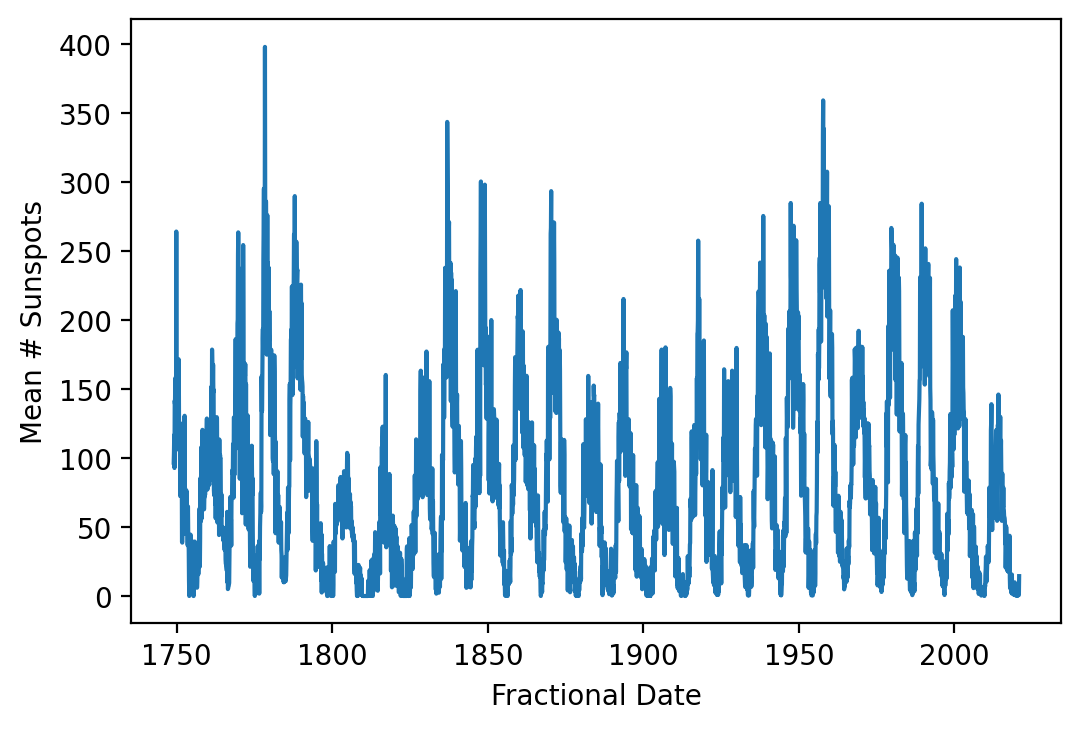

In [6]:
fig,ax=plt.subplots()
ax.plot(df["Frac. Date"],df.Mean)  #Either get columns via 
ax.set_xlabel("Fractional Date")
ax.set_ylabel("Mean # Sunspots")

## Preparing the data
To prepare the data for training the network we need to change it into a format where the data has some sequence (to use as the input) and some data value (to use as the target). We will do this by creating sequences of $n_{ts}$ consecutive values, with the target $offset$ values later.

In [7]:
#Function to convert a series with data values into a dataframe of n_ts values 
# with a target offset samples later
def make_timeseqs(series,n_ts,offset):
    nn_df = pd.DataFrame()
    for i in range(n_ts):
        nn_df[i] = series.shift(n_ts-i) #Shift the data by n_ts-i samples
    nn_df['label'] = series.shift(-offset)
    return nn_df

In [8]:
df.Mean=df.Mean/df.Mean.max()
offset=0
n_ts=6 #Number of values in a time sequence
nn_df=make_timeseqs(df.Mean,n_ts,offset) #6 samples per row for training, offset of 0 (so next sample)
nn_df.head(8)

,0,1,2,3,4,5,label
0,NaN,NaN,NaN,NaN,NaN,NaN,0.242843
1,NaN,NaN,NaN,NaN,NaN,0.242843,0.261929
2,NaN,NaN,NaN,NaN,0.242843,0.261929,0.293069
3,NaN,NaN,NaN,0.242843,0.261929,0.293069,0.233049
4,NaN,NaN,0.242843,0.261929,0.293069,0.233049,0.355851
5,NaN,0.242843,0.261929,0.293069,0.233049,0.355851,0.349573
6,0.242843,0.261929,0.293069,0.233049,0.355851,0.349573,0.396786
7,0.261929,0.293069,0.233049,0.355851,0.349573,0.396786,0.277499


### Cleaning the data
Clearly the shifted data results in a number of NaN (Not a Number) values populating the DataFrame. We need to throw away these values and just keep those rows which have all valid data

In [9]:
nn_df.dropna(axis=0, inplace=True)
nn_df.head()

,0,1,2,3,4,5,label
6,0.242843,0.261929,0.293069,0.233049,0.355851,0.349573,0.396786
7,0.261929,0.293069,0.233049,0.355851,0.349573,0.396786,0.277499
8,0.293069,0.233049,0.355851,0.349573,0.396786,0.277499,0.317680
9,0.233049,0.355851,0.349573,0.396786,0.277499,0.317680,0.315922
10,0.355851,0.349573,0.396786,0.277499,0.317680,0.315922,0.663737


### Creating, train, validation and testing data samples
We want to create training, validation and testing data samples from these rows. The input data needs to have the shape `(num_rows, num_time_seqs, num_features)`. For the sunspot data the `num_features` is just 1 and `num_time_seqs` is 6 in this example


In [10]:
train_label=nn_df.label.values
train_data=nn_df.drop('label',axis=1).values
print(train_data.shape)
train_data=train_data.reshape(-1,n_ts,1)
print(train_data.shape)
print(train_label.shape)

(3256, 6)
(3256, 6, 1)
(3256,)


In [11]:
test_data=train_data[-100:]
test_label=train_label[-100:]
train_data=train_data[:-100]
train_label=train_label[:-100]

from sklearn.model_selection import train_test_split
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, random_state = 0)
print(train_data.shape)

(2367, 6, 1)


## Define our model

In [12]:
model=keras.models.Sequential()
model.add(keras.layers.LSTM(64,input_shape=(n_ts,1),return_sequences=True)) # LSTM layer with 50 neurons
model.add(keras.layers.LSTM(32,activation='relu'))
model.add(keras.layers.Dense(32,activation='relu'))
model.add(keras.layers.Dense(1,activation="linear"))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 64)             16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________


In [13]:
history=model.fit(train_data,train_label,epochs=10,batch_size=16,verbose=1,validation_data=(val_data,val_label))

Epoch 1/10
148/148 [==============================] - 1s 10ms/step - loss: 0.0107 - val_loss: 0.0059
Epoch 2/10
148/148 [==============================] - 1s 6ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 3/10
148/148 [==============================] - 1s 6ms/step - loss: 0.0052 - val_loss: 0.0055
Epoch 4/10
148/148 [==============================] - 1s 6ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 5/10
148/148 [==============================] - 1s 5ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 6/10
148/148 [==============================] - 1s 5ms/step - loss: 0.0045 - val_loss: 0.0046
Epoch 7/10
148/148 [==============================] - 1s 5ms/step - loss: 0.0044 - val_loss: 0.0046
Epoch 8/10
148/148 [==============================] - 1s 5ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 9/10
148/148 [==============================] - 1s 5ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 10/10
148/148 [==============================] - 1s 5ms/step - loss: 0.0042 - val_loss: 0.004

### Plot some things


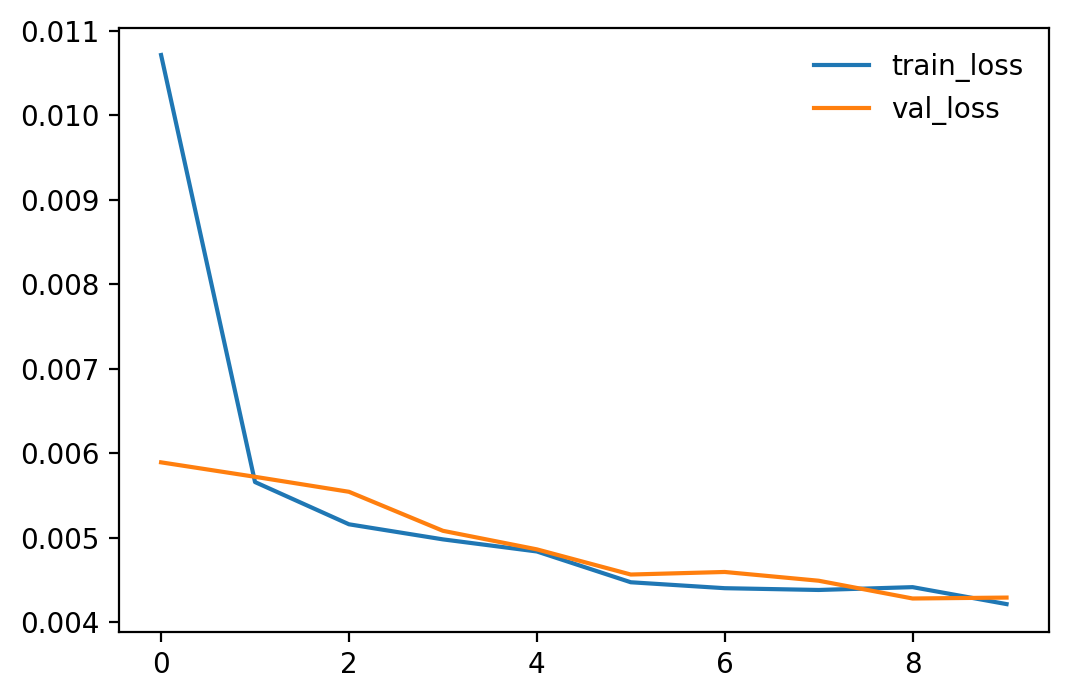

In [14]:
fig,ax=plt.subplots()
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.set_title = 'Loss of the model'
ax.xlabel = 'Time (Epochs)'
ax.ylabel = 'Loss'
ax.legend()

### Predict the future

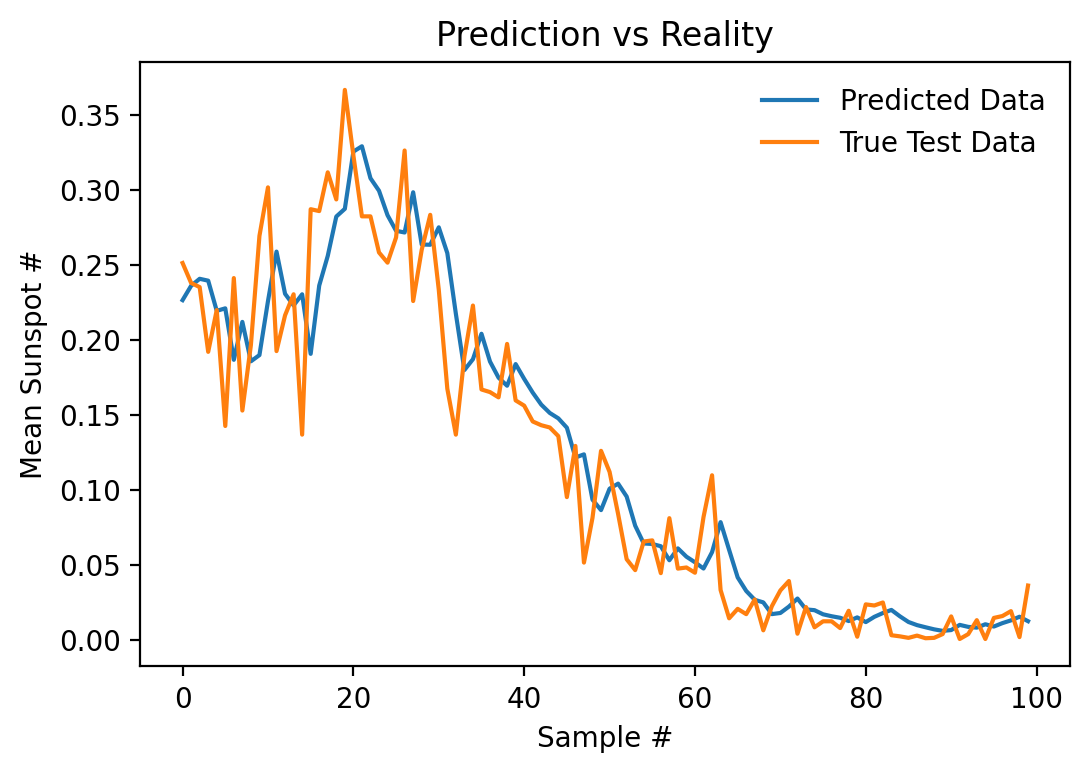

In [17]:
test_predict=model.predict(test_data)
fig,ax=plt.subplots()
ax.plot(test_predict[offset:],label="Predicted Data")
ax.plot(test_label,label="True Test Data")
ax.set_title("Prediction vs Reality")
ax.set_xlabel("Sample #")
ax.set_ylabel("Mean Sunspot #")
ax.legend()


Clearly the model does a reasonable job of predicting the underlying trends (if the high variability in the true data is just statictical noise (we expect the number of sunspots each month to have standard Poissonian counting statistics) the arguable we should want our model not to try and follow those noise wiggles).

## Suggested tasks
1. Change the network architechture (reduce or remove LSTM layers)
2. Try and predict over longer time periods (increase the offset)
3. Investigate the stability of your predictions vs some of the hyper parameters (sequence length, offset, learning rate, etc.)